In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

In [4]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


## Description

This Kaggle competition uses NLP to predict whether a tweet is describing a disaster or not. This notebook aims to train a model to deduce with decent accuracy if a tweet is a real disaster or not. To being, the following code is simply to get a general overview of the dataset, to understand how I can manipulate the data and figure out the end goal.

In [5]:
train_dir = '/kaggle/input/nlp-getting-started/train.csv'
test_dir = '/kaggle/input/nlp-getting-started/test.csv'

train_df = pd.read_csv(train_dir)
test_df = pd.read_csv(test_dir)
print(train_df.head(10))


print("Training data shape:", train_df.shape)
print("Training data info:")
print(train_df.info())

print("\nTest data shape:", test_df.shape)
print("Test data info:")
print(test_df.info())


print("Missing values in Training Data:\n", train_df.isnull().sum())
print("\nMissing values in Test Data:\n", test_df.isnull().sum())

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   
5   8     NaN      NaN  #RockyFire Update => California Hwy. 20 closed...   
6  10     NaN      NaN  #flood #disaster Heavy rain causes flash flood...   
7  13     NaN      NaN  I'm on top of the hill and I can see a fire in...   
8  14     NaN      NaN  There's an emergency evacuation happening now ...   
9  15     NaN      NaN  I'm afraid that the tornado is coming to our a...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
5       1  
6       1  
7       1  
8       1  
9       1  
Training data shape:

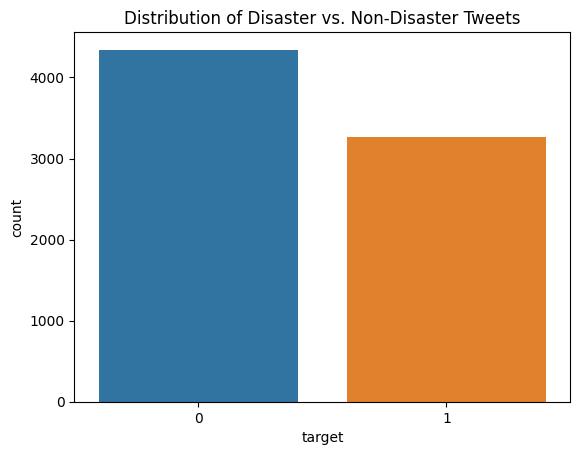

Example Tweets from the Training Data:
['Sydney hostage crisis has now been recovered from the AirAsia wreckage.'
 'As a result of heavy rains in #Bangladeshaffected lands are inundated by flood waters-land looks like rivers at high tide #BangladeshFlood'
 "@ItsQueenBaby I'm at work it's a bunch of ppl and buses because the train derailed"
 'I added a video to a @YouTube playlist http://t.co/612BsbVw8K siren 1 gameplay/walkthrough part 1'
 "@eunice_njoki aiii she needs to chill and answer calmly its not like she's being attacked"]


In [6]:
# Distribution of target labels in training data
sns.countplot(x='target', data=train_df)
plt.title('Distribution of Disaster vs. Non-Disaster Tweets')
plt.show()

# Displaying some example tweets
print("Example Tweets from the Training Data:")
print(train_df['text'].sample(5).values)

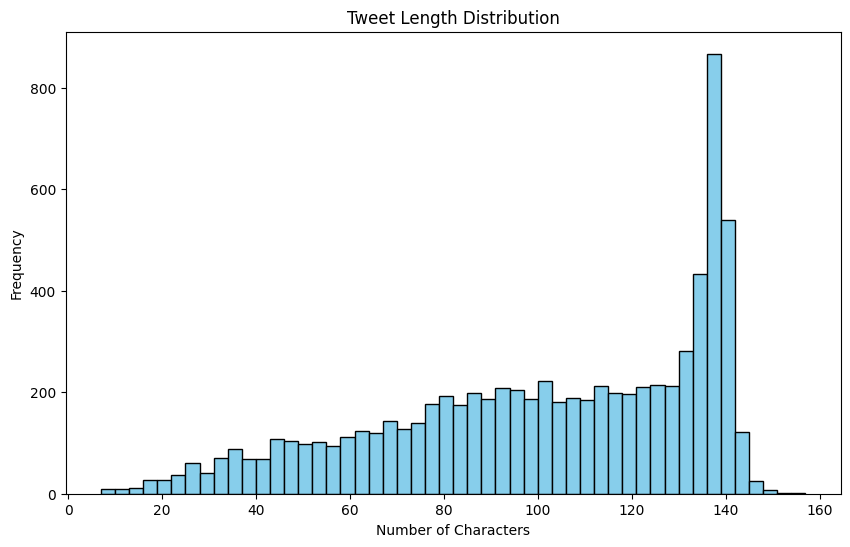

In [7]:
# Calculate the length of each tweet
train_df['text_length'] = train_df['text'].apply(len)

# Plot histogram of tweet lengths
plt.figure(figsize=(10, 6))
plt.hist(train_df['text_length'], bins=50, color='skyblue', edgecolor='black')
plt.title('Tweet Length Distribution')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()

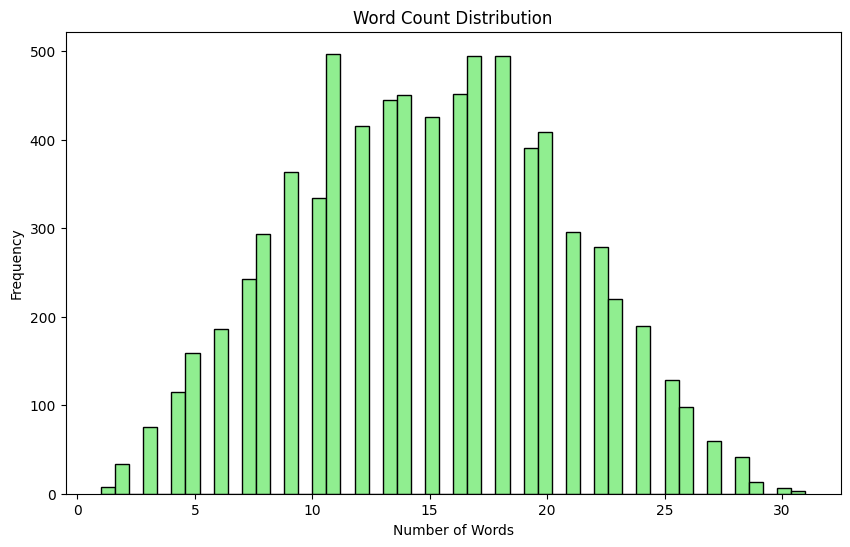

In [8]:
# Calculate the number of words in each tweet
train_df['word_count'] = train_df['text'].apply(lambda x: len(x.split()))

# Plot histogram of word counts
plt.figure(figsize=(10, 6))
plt.hist(train_df['word_count'], bins=50, color='lightgreen', edgecolor='black')
plt.title('Word Count Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

## Data Cleaning

I am doing some simple data cleaning, removing nulls, and using spacy to clean the text by putting all the sentences to lower and lemmatizing. I would have used the nltk library but for some reason kaggle doesnt recognize my root folder even if I download it correctly to the dirrectory. I was very unfamiliar with spacy so I utilized another notebook and "realpython.com" to implement spacy.

Notebook: https://www.kaggle.com/code/anthonyylee/lstm-tweets

RealPython: https://realpython.com/natural-language-processing-spacy-python/

I then pipe the cleaned text into a new column just for simplicity and to ensure I use my cleaned data for my analysis.

In [9]:
train_df['keyword'].fillna('unknown', inplace=True)
train_df['location'].fillna('unknown', inplace=True)

train_df = train_df.drop_duplicates(subset=['text', 'target'])

# Check if duplicates were removed
print(f"Data after removing duplicates: {train_df.shape[0]} rows")



# Load spaCy's English model
nlp = spacy.load("en_core_web_sm")

# Function to clean and lemmatize text using spaCy
def clean_text_spacy(text):
    # Process text through spaCy pipeline
    doc = nlp(text.lower())  # Convert to lowercase and process
    # Lemmatize and remove stopwords
    lemmatized_text = " ".join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])
    return lemmatized_text

# Apply this function to the training and test datasets
train_df['cleaned_text'] = train_df['text'].apply(clean_text_spacy)
test_df['cleaned_text'] = test_df['text'].apply(clean_text_spacy)

/tmp/ipykernel_24/960166674.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['keyword'].fillna('unknown', inplace=True)
/tmp/ipykernel_24/960166674.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

Data after removing duplicates: 7521 rows


## TFIDF and Padding

In [10]:
# Initialize the TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=5000)

# Fit and transform the training data, transform the test data
X_train = tfidf.fit_transform(train_df['cleaned_text'])
X_test = tfidf.transform(test_df['cleaned_text'])

# Target labels for training
y_train = train_df['target']

I picked TFID from the rubric as my text-to-matrix method. As geek for geeks states, TF-IDF is a methad for calculating the importance of a word through "Term Frequency" and "Invserse Document Frequency". The simplistic forumula goes as such: you multiply the "frequency of a word in a document full of words" with the "how common a word is among all documents". This then gives you a combined "importance" score to then determine if a word is worth keeping or not. Utilizing this method allows for us to prepare the text to be fed into the LSTM by vetorizing the text. The code bellow also ensures padding so each sentence is of similar length, this helps with quicker and more even processing while training.

In [11]:
# Initialize the Tokenizer
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['cleaned_text'])

# Convert text to sequences (numerical representation)
X_train_seq = tokenizer.texts_to_sequences(train_df['cleaned_text'])
X_test_seq = tokenizer.texts_to_sequences(test_df['cleaned_text'])

# Pad sequences to ensure uniform length
max_length = 100  # Adjust as necessary
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')


## Model Structure

In [12]:
# Model architecture
model = Sequential()

# Embedding layer for word vectors
model.add(Embedding(input_dim=5000, output_dim=64, input_length=max_length))

# Bidirectional LSTM layer (You can change LSTM to GRU or standard RNN)
model.add(Bidirectional(LSTM(64, return_sequences=False)))

# Dropout for regularization
model.add(Dropout(0.5))

# Output layer
model.add(Dense(1, activation='sigmoid'))  # Binary classification (disaster vs. non-disaster)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [13]:
# Model architecture
model1 = Sequential()

# Embedding layer for word vectors
model1.add(Embedding(input_dim=5000, output_dim=64, input_length=max_length))

# Bidirectional LSTM layer (You can change LSTM to GRU or standard RNN)
model1.add(Bidirectional(LSTM(64, return_sequences=False)))

# Dropout for regularization
model1.add(Dropout(0.5))

# Output layer
model1.add(Dense(1, activation='sigmoid'))  # Binary classification (disaster vs. non-disaster)

# Compile the model
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
# Model architecture
model2 = Sequential()

# Embedding layer for word vectors
model2.add(Embedding(input_dim=5000, output_dim=64, input_length=max_length))

# Bidirectional LSTM layer (You can change LSTM to GRU or standard RNN)
model2.add(Bidirectional(LSTM(64, return_sequences=False)))

# Dropout for regularization
model2.add(Dropout(0.5))

# Output layer
model2.add(Dense(1, activation='sigmoid'))  # Binary classification (disaster vs. non-disaster)

# Compile the model
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## Training and Visualization

In [15]:
# Train the model
history = model.fit(X_train_padded, y_train, epochs=5, batch_size=64, validation_split=0.2)

Epoch 1/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - accuracy: 0.6024 - loss: 0.6551 - val_accuracy: 0.7721 - val_loss: 0.4928
Epoch 2/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.8307 - loss: 0.4076 - val_accuracy: 0.8093 - val_loss: 0.4346
Epoch 3/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - accuracy: 0.8903 - loss: 0.2931 - val_accuracy: 0.8066 - val_loss: 0.4534
Epoch 4/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.9113 - loss: 0.2358 - val_accuracy: 0.7900 - val_loss: 0.5213
Epoch 5/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.9347 - loss: 0.1908 - val_accuracy: 0.7867 - val_loss: 0.5667


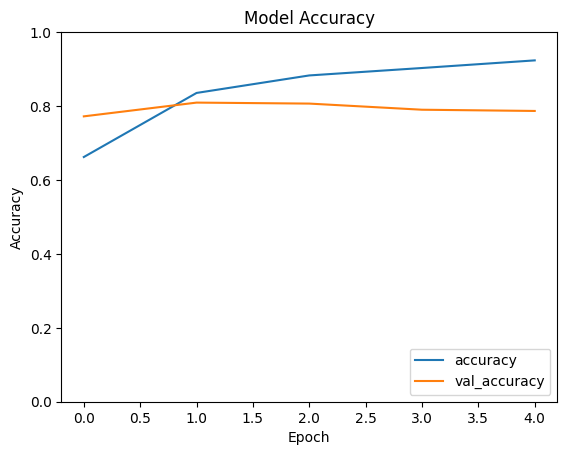

In [16]:
# Plotting the training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Model Accuracy')
plt.show()


## Testing Hyperparameters

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.6311 - loss: 0.6340 - val_accuracy: 0.8073 - val_loss: 0.4378
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.8532 - loss: 0.3696 - val_accuracy: 0.7934 - val_loss: 0.4443
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.8908 - loss: 0.2848 - val_accuracy: 0.7927 - val_loss: 0.5020
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.9205 - loss: 0.2211 - val_accuracy: 0.7615 - val_loss: 0.5891
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.9430 - loss: 0.1712 - val_accuracy: 0.7442 - val_loss: 0.6347
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.9526 - loss: 0.1438 - val_accuracy: 0.7462 - val_loss: 0.8197
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.9634 - loss: 0.1052 - val_accuracy: 0.7429 - val_loss: 0.8151
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.9651 - loss: 0.1034 - 

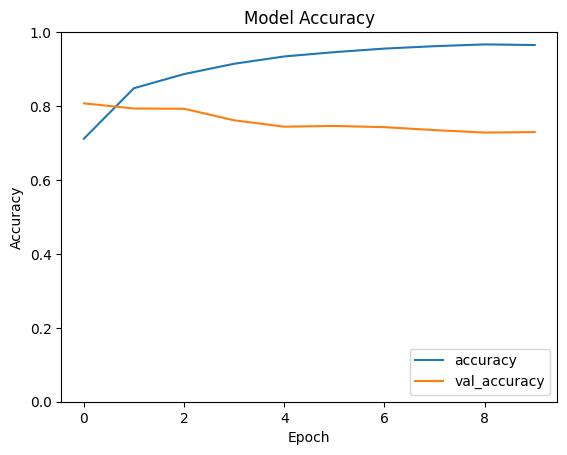

In [17]:
history = model1.fit(X_train_padded, y_train, epochs=10, batch_size=32, validation_split=0.2)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Model Accuracy')
plt.show()


Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 186ms/step - accuracy: 0.5854 - loss: 0.6661 - val_accuracy: 0.7422 - val_loss: 0.5734
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 0.7721 - loss: 0.5086 - val_accuracy: 0.8060 - val_loss: 0.4457
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 0.8601 - loss: 0.3392 - val_accuracy: 0.8013 - val_loss: 0.4499
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.9065 - loss: 0.2583 - val_accuracy: 0.8007 - val_loss: 0.4722
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.9151 - loss: 0.2301 - val_accuracy: 0.7880 - val_loss: 0.5196
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 0.9308 - loss: 0.1906 - val_accuracy: 0.7688 - val_loss: 0.6096
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.9424 - loss: 0.1653 - val_accuracy: 0.7648 - val_loss: 0.6806
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.9465 - loss: 0.1478 - val_accuracy: 0

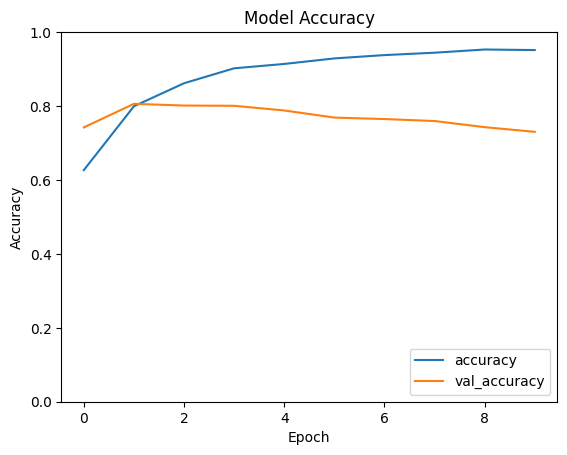

In [18]:
history = model2.fit(X_train_padded, y_train, epochs=10, batch_size=128, validation_split=0.2)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Model Accuracy')
plt.show()


## Discussion

The above cases were to demonstrate the importance to tuning the hyperparameters to determine the best combination for an accurate model. From the tests, I can conclude that it would be best to use "model" since it yeilded the highest score and didn't sacrifice too much computational time. This is a very crude way of achieving tuning and is only demosntrated this way due to time constraints. Tuning takes hours of work to perfect but I just wanted to demonstrate what changing some values could accomplish. This code has tons of room for improvement and with enough time and dedication I am sure this would turn out to be a better score, this is simply a baseline for understanding the use cases for the LSTM model.

## Predict

In [19]:
# Predict on the training data
train_pred = model.predict(X_train_padded)

# Convert predictions from probabilities to binary outcomes (0 or 1)
train_pred_binary = (train_pred > 0.5).astype(int)

# Evaluate model on the training set
from sklearn.metrics import accuracy_score, classification_report

train_accuracy = accuracy_score(y_train, train_pred_binary)
print(f'Training Accuracy: {train_accuracy}')
print(classification_report(y_train, train_pred_binary))

236/236 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step
Training Accuracy: 0.9130434782608695
              precision    recall  f1-score   support

           0       0.90      0.95      0.93      4315
           1       0.93      0.86      0.89      3206

    accuracy                           0.91      7521
   macro avg       0.92      0.91      0.91      7521
weighted avg       0.91      0.91      0.91      7521



## Submission

In [20]:
# Predict on the test data
test_pred = model.predict(X_test_padded)

# Convert predictions from probabilities to binary outcomes (0 or 1)
test_pred_binary = (test_pred > 0.5).astype(int)
test_pred_binary = test_pred_binary.flatten()
print(test_pred_binary.shape)
print(test_df.shape)  
submission = pd.DataFrame({'id': test_df['id'], 'target': test_pred_binary})
print(submission.head())
submission.to_csv('submission.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
(3263,)
(3263, 5)
   id  target
0   0       0
1   2       1
2   3       1
3   9       1
4  11       1
